In [1]:
%load_ext autoreload
%autoreload 

In [ ]:
import math
from types import SimpleNamespace

from clip_sdf import SDFOptimizer

ClipLoss device cuda


In [ ]:
optim_config = SimpleNamespace(
    learning_rate=0.008,
    batch_size=1,
    init_tolerance=-0.2,
    iters_per_res=6,
    max_iters_per_cam=16,
    camera=SimpleNamespace(
        max_num_cameras=16,
        init_num_cameras=8,
        mapping_span=math.pi,
        shuffle_order=False,
        mapping_type="linear",
    ),
    loss=SimpleNamespace(
        image_loss_weight=1 / 10,
        sdf_loss_weight=1 / 1000,
        lp_loss_weight=1 / 1000,
    ),
)





image loss:  tensor(18.2500, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) 

sdf loss:  tensor(5.9618, device='cuda:0', grad_fn=<MulBackward0>) 

lp loss:  tensor(0.3847, device='cuda:0', grad_fn=<MulBackward0>) 

loss:  tensor(48.3491, device='cuda:0', grad_fn=<DivBackward0>) 

tolerance: -0.05 


sdf grid res: 64  - iteration: 4  -  cam view idx 15  -  cam iters: 1


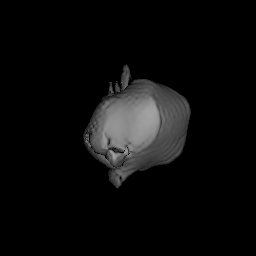

In [4]:
sdf_optimizer = SDFOptimizer(
    config=optim_config,
    sdf_grid_res_list = [16, 24, 40, 64],


)

sdf_optimizer.clip_sdf_optimization(
    prompt="3D bunny rabbit mesh rendered with maya zbrush",
    experiment_name="test",
)

In [5]:
import os
from IPython.display import Video

In [6]:
sdf_optimizer.generate_visualizations()

Generating ./experiments/test-80/visualizations/generation.mp4


ffmpeg version 4.1.6-1~deb10u1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --prefix=/usr --extra-version='1~deb10u1' --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --

Generating ./experiments/test-80/visualizations/visualization.mp4


ffmpeg version 4.1.6-1~deb10u1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --prefix=/usr --extra-version='1~deb10u1' --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --

In [7]:
os.path.join(sdf_optimizer.results_dir, "visualizations", 'generation.mp4')

'./experiments/test-80/visualizations/generation.mp4'

In [8]:
Video(os.path.join(sdf_optimizer.results_dir, "visualizations", 'generation.mp4'))

In [9]:
Video(os.path.join(sdf_optimizer.results_dir, "visualizations", 'visualization.mp4'))